In [52]:
import Pkg
Pkg.add("Turing")
Pkg.add("DifferentialEquations")
Pkg.add("Distributions")
Pkg.add("StatsPlots")
Pkg.add("Plots")
Pkg.add("ReverseDiff")
Pkg.add("Memoization")


  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
  [fce5fe82] + Turing v0.13.0
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [80f14c24] + AbstractMCMC v1.0.1
  [1520ce14] + AbstractTrees v0.3.3
  [79e6a3ab] + Adapt v2.0.2
  [0bf59076] + AdvancedHMC v0.2.25
  [5b7e9947] + AdvancedMH v0.5.1
  [dce04be8] + ArgCheck v2.1.0
  [7d9fca2a] + Arpack v0.4.0
  [68821587] + Arpack_jll v3.5.0+3
  [4fba245c] + ArrayInterface v2.11.0
  [39de3d68] + AxisArrays v0.4.3
  [6e4b80f9] + BenchmarkTools v0.5.0
  [76274a88] + Bijectors v0.7.2
  [b99e7846] + BinaryProvider v0.5.10
  [861a8166] + Combinatorics v1.0.2
  [bbf7d656] + CommonSubexpressions v0.3.0
  [34da2185] + Compat v3.13.0
  [e66e0078] + CompilerSupportLibraries_jll v0.3.3+0
  [88cd18e8] + ConsoleProgressMonitor v0.1.2
  [9a962f9c] + DataAPI v1.3.0
  [864edb3b] + DataStructures v0.17.19
  [163ba53b] + DiffResults v1.0.2
  [b552c78f] + DiffRules v1.0.1
  [31c24e10] + Distributions v0.23.4
  [ced4e74

  [13072b0f] + AxisAlgorithms v1.0.0
  [6e34b625] + Bzip2_jll v1.0.6+2
  [aaaa29a8] + Clustering v0.14.1
  [35d6a980] + ColorSchemes v3.9.0
  [3da002f7] + ColorTypes v0.10.7
  [5ae59095] + Colors v0.12.3
  [d38c429a] + Contour v0.5.4
  [e2d170a0] + DataValueInterfaces v1.0.0
  [e7dc6d0d] + DataValues v0.4.13
  [c87230d0] + FFMPEG v0.3.0
  [b22a6f82] + FFMPEG_jll v4.1.0+3
  [7a1cc6ca] + FFTW v1.2.2
  [f5851436] + FFTW_jll v3.3.9+5
  [53c48c17] + FixedPointNumbers v0.8.4
  [d7e528f0] + FreeType2_jll v2.10.1+2
  [559328eb] + FriBidi_jll v1.0.5+3
  [28b8d3ca] + GR v0.51.0
  [5c1252a2] + GeometryBasics v0.2.15
  [4d00f742] + GeometryTypes v0.8.3
  [cd3eb016] + HTTP v0.8.17
  [83e8ac13] + IniFile v0.5.0
  [1d5cc7b8] + IntelOpenMP_jll v2018.0.3+0
  [a98d9a8b] + Interpolations v0.12.10
  [5ab0869b] + KernelDensity v0.5.1
  [c1c5ebd0] + LAME_jll v3.100.0+1
  [dd192d2f] + LibVPX_jll v1.8.1+1
  [856f044c] + MKL_jll v2020.1.216+0
  [739be429] + MbedTLS v1.0.2
  [c8ffd9c3] + MbedTLS_jll v2.16.6+1
 

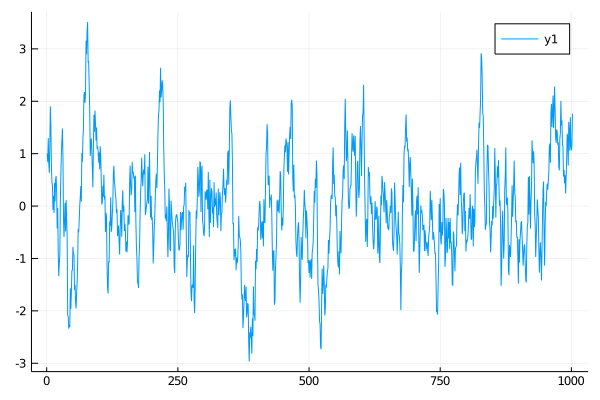

In [53]:
using DifferentialEquations
using Plots

μ = 0.0
σ = sqrt(2)
Θ = 1.0
W = OrnsteinUhlenbeckProcess(Θ,μ,σ,0.0,1.0)
prob = NoiseProblem(W,(0.0,100.0))
sol = solve(prob;dt=0.1)
plot(sol.u)

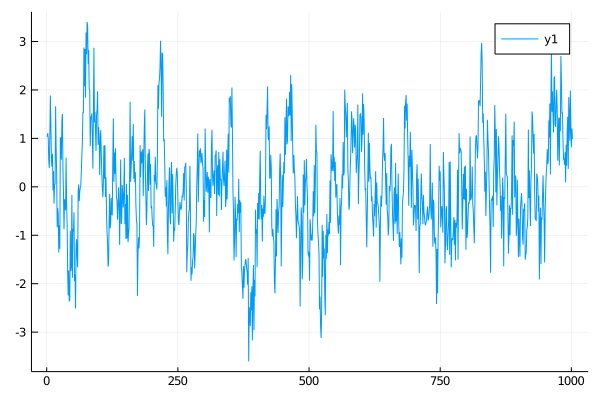

In [54]:
using Distributions, Random
ou_data = sol.u
noise = rand(Normal(0,0.4), length(ou_data))
plot(ou_data.+noise)

In [55]:
using Turing, ReverseDiff, Memoization
Turing.setadbackend(:reversediff)
Turing.setrdcache(true)
using Distributions
using LinearAlgebra

# Ornstein-Uhlenbeck process
@model ou(rn,T,delta_t) = begin
    ampl ~ Uniform(0.0,5.0)
    tau ~ Uniform(0.0,5.0)
    
    b = exp(-delta_t/tau)
    
    rn[1] ~ Normal(0,sqrt(ampl))
    
    for i=2:T
        rn[i] ~ Normal(rn[i-1]*b,sqrt(ampl*(1-b^2)))
    end
end

# Ornstein-Uhlenbeck process with added Gaussian noise
@model oupn(rn,T,delta_t,::Type{R}=Vector{Float64}) where {R} = begin
    ampl ~ Uniform(0.0,5.0)
    tau ~ Uniform(0.0,5.0)
    noise_ampl ~ Uniform(0.0,1)
    
    b = exp(-delta_t/tau)
    r = R(undef, T)
    
    r[1] ~ Normal(0,sqrt(ampl))
    
    for i=2:T
        r[i] ~ Normal(r[i-1]*b,sqrt(ampl*(1-b^2)))
    end
    rn ~ MvNormal(r,sqrt(noise_ampl))
end

┌ Info: Precompiling ReverseDiff [37e2e3b7-166d-5795-8a7a-e32c996b4267]
└ @ Base loading.jl:1260
┌ Info: Precompiling Memoization [6fafb56a-5788-4b4e-91ca-c0cea6611c73]
└ @ Base loading.jl:1260


DynamicPPL.ModelGen{var"###generator#2925",(:rn, :T, :delta_t, :R),(:R,),Tuple{Type{Array{Float64,1}}}}(##generator#2925, NamedTuple{(:R,),Tuple{Type{Array{Float64,1}}}}((Array{Float64,1},)))

In [56]:
using StatsPlots
@time chnou = sample(ou(ou_data,length(ou_data),0.1), NUTS(0.65), 2000)
# Summarise results (currently requires the master branch from MCMCChains)
describe(chnou)


 40.914045 seconds (580.59 M allocations: 9.339 GiB, 5.29% gc time)


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/hstrey/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/hstrey/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47


2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
        ampl  1.1084  0.1838    0.0058  0.0099  184.8000  1.0007
         tau  1.0748  0.1868    0.0059  0.0101  187.9074  1.0008

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
        ampl  0.8104  0.9814  1.0845  1.2133  1.5615
         tau  0.7799  0.9490  1.0469  1.1822  1.5444


In [57]:
using StatsPlots
data = ou_data .+ noise
@time chnpn = sample(oupn(data,length(data),0.1), NUTS(0.65), 2000)
describe(chnpn)

 94.766975 seconds (1.85 G allocations: 53.037 GiB, 8.99% gc time)


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/hstrey/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/hstrey/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/hstrey/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/hstrey/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/hstrey/.julia/packages/AdvancedHMC/P9wqk/s

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean     std  naive_se    mcse        ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ─────────  ──────
        ampl   1.1190  0.1884    0.0060  0.0103   337.9817  1.0021
  noise_ampl   0.1487  0.0172    0.0005  0.0022    66.7963  1.0032
        r[1]   0.9805  0.2996    0.0095  0.0112   710.7894  0.9995
        r[2]   1.0232  0.2814    0.0089  0.0102   894.2209  1.0005
        r[3]   0.9105  0.2855    0.0090  0.0090   904.3431  0.9991
        r[4]   0.6707  0.2967    0.0094  0.0079   832.6510  1.0009
        r[5]   0.6507  0.2743    0.0087  0.0073  1017.7267  0.9995
        r[6]   1.0467  0.2784    0.0088  0.0105   962.9898  1.0027
        r[7]   1.4361  0.2933    0.0093  0.0110   848.0986  0.9991
        r[8]   1.1834  0.2746    0.0087  0.0083  1052.4449  0.9991
        r[9]   0.7090  0.2739    0.0087  0.0075  1025.0857  0.9990
       r[10]   0.5085  0.2760    0.0087  0.0075   921.2121  0.9991
       r

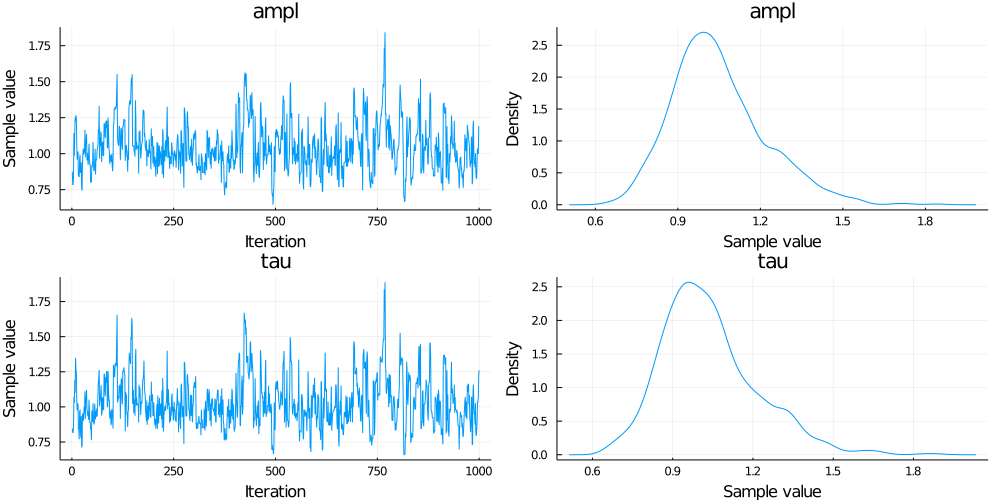

In [36]:
# Plot and save results
using Plots
p = plot(chn)

1.0917570184929886

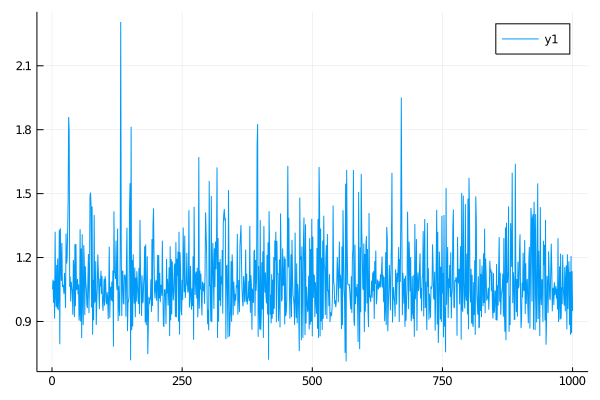

In [48]:
ampl_data = chnpn[:ampl].value.data
print(mean(ampl_data[:,1,1]))
plot(ampl_data[:,1,1])

In [49]:
r_data = chnpn[:r].value.data
r_mean=mean(r_data,dims=1)[1,:,1]

1002-element Array{Float64,1}:
  1.1729601975058386
  1.376086043053466
  0.8750202005445756
  0.41791978661624296
  0.24108458689083692
  0.380537925649892
  0.17911943958439142
  0.10496978489215396
 -0.05484711470881756
  0.13364849632845263
 -0.04042903456509873
  0.0502522888583229
  0.317246296078771
  ⋮
 -1.309830375127741
 -1.4805345848402143
 -2.3535667669233464
 -2.355610415376828
 -2.1287974461875634
 -1.298290085814181
 -1.5469271335326151
 -1.7323395349454402
 -1.6582589063945796
 -1.5444741378723734
 -1.7126201289240512
 -1.6612674031306733

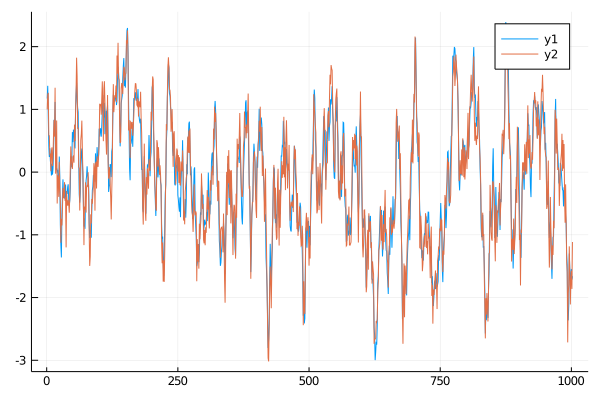

In [50]:
plot(r_mean)
plot!(sol.u)

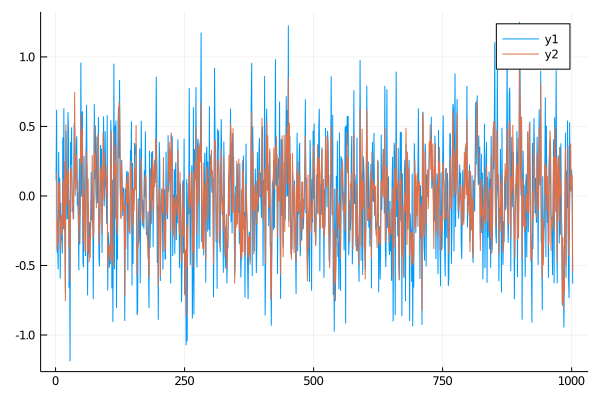

In [51]:
plot(noise)
plot!(r_mean.-sol.u)